Eye disease detection using resnet with explainable AI

# Libraries

In [1]:
!pip install kneed

In [2]:
!pip install numpy pandas seaborn torch torchvision timm kneed scikit-learn matplotlib pillow


In [3]:
import os
import numpy as np
import pandas as pd
import shutil
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import datasets, transforms, models
import timm
from kneed import KneeLocator
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, ParameterGrid
import matplotlib.pyplot as plt
from PIL import Image
import warnings

c:\Users\PRABHAKARAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

# Data Pre Processing

In [5]:
#!unzip '/content/drive/My Drive/ocular-disease-recognition-odir5k.zip' -d /content

In [6]:
import zipfile
import os

In [68]:
# Suppressing warning messages to avoid cluttering the output
warnings.filterwarnings("ignore")

In [8]:
zip_path = "D:\\MIA\\6th Sem\\PACS\\ocular-disease-recognition-odir5k.zip"  

extract_path = "D:\\MIA\\6th Sem\\PACS\\ds"  


In [9]:
# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete! Files are in:", extract_path)


Extraction complete! Files are in: D:\MIA\6th Sem\PACS\ds


In [10]:
# Reading the CSV file into a DataFrame for data processing
df = pd.read_csv("D:\\MIA\\6th Sem\\PACS\\ds\\full_df.csv")

In [11]:
df.head(2)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   

  Left-Diagnostic Keywords Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                 cataract             normal fundus  0  0  0  1  0  0  0  0   
1            normal fundus             normal fundus  1  0  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg

In [12]:
# Setting the display option to show all rows in the DataFrame when printing
pd.set_option('display.max_rows', None)

In [13]:
# Setting the display option to show all rows in the DataFrame when printing
pd.set_option('display.max_rows', None)

In [14]:
pd.set_option('display.max_rows', None)
# Defining the custom function for exact keyword matching to specific labels
def map_to_label_exact(keyword):
    if keyword == 'normal fundus':
        return 'Normal Fundus'
    elif keyword == 'retinopathy':
        return 'Diabetes'
    elif keyword == 'severe nonproliferative retinopathy':
        return 'Diabetes'
    elif keyword == 'cataract':
        return 'Cataract'
    elif keyword == 'moderate non proliferative retinopathy':
        return 'Diabetes'
#     elif keyword == 'pathological myopia':
#         return 'Pathological Myopia'
#     elif keyword == 'dry age-related macular degeneration':
#         return 'Age-related Macular Degeneration'
    elif keyword == 'glaucoma':
        return 'Glaucoma'
    elif keyword == 'drusen':
        return 'Drusen'
#     elif keyword == 'hypertensive retinopathy':
#         return 'Hypertension'
    else:
        return 'Other diseases/abnormalities'

In [15]:
# Applying the custom function to map the 'Right-Diagnostic Keywords' and 'Left-Diagnostic Keywords' columns
df['right_label_column'] = df['Right-Diagnostic Keywords'].apply(map_to_label_exact)
df['left_label_column'] = df['Left-Diagnostic Keywords'].apply(map_to_label_exact)

In [16]:
# Creating separate DataFrames for right and left eye diagnostic keywords and labels
df_right = df[['Right-Diagnostic Keywords', 'right_label_column']]
df_left = df[['Left-Diagnostic Keywords', 'left_label_column']]


In [17]:
# Concatenating the 'Right-Fundus' image file paths to the 'df_right' DataFrame
df_right = pd.concat([df_right, df[['Right-Fundus']]], axis=1)

# Renaming columns in 'df_right' to more descriptive names
df_right.rename(columns={"right_label_column": "disease", "Right-Fundus": "image_file"}, inplace=True)

# Dropping the original 'Right-Diagnostic Keywords' column from 'df_right' since it's no longer needed
df_right.drop("Right-Diagnostic Keywords", axis=1, inplace=True)

# Concatenating the 'Left-Fundus' image file paths to the 'df_left' DataFrame
df_left = pd.concat([df_left, df[['Left-Fundus']]], axis=1)

# Renaming columns in 'df_left' to more descriptive names
df_left.rename(columns={"left_label_column": "disease", "Left-Fundus": "image_file"}, inplace=True)

# Combining the 'df_right' and 'df_left' DataFrames into a single DataFrame 'df_labeled'
df_labeled = pd.concat([df_right, df_left])

# Dropping the original 'Left-Diagnostic Keywords' column from 'df_labeled' since it's no longer needed
df_labeled.drop("Left-Diagnostic Keywords", axis=1, inplace=True)



In [18]:
# Counting the occurrences of each disease label in the 'disease' column
df_labeled['disease'].value_counts()

disease
Normal Fundus                   5501
Other diseases/abnormalities    4350
Diabetes                        1748
Cataract                         518
Glaucoma                         397
Drusen                           270
Name: count, dtype: int64

In [19]:
# Filtering 'df_labeled' to include only rows where the 'disease' column has values 'Glaucoma', 'Cataract', or 'Diabetes'
df_labeled = df_labeled.loc[(df_labeled['disease'] == 'Glaucoma') |
                            (df_labeled['disease'] == 'Cataract') |
                            (df_labeled['disease'] == 'Diabetes')]

In [20]:
# Creating the main directory 'classified_images/train' and any necessary parent directories if they do not already exist
base_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train"
os.makedirs(base_dir, exist_ok=True)

In [21]:
# Creating subdirectories for each unique label in 'df_labeled'
labels = df_labeled['disease'].unique()
for label in labels:
    os.makedirs(os.path.join(base_dir, label), exist_ok=True)

In [22]:
# Defining the source directory containing the images
source_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\preprocessed_images"

In [23]:
# Iterating over each row in 'df_labeled' to copy images to the corresponding folders
for index, row in df_labeled.iterrows():
    source_file = os.path.join(source_dir, row['image_file'])  # Constructing the path to the image in the source directory
    label = row['disease']  # Getting the label for the image
    dest_folder = os.path.join(base_dir, label)  # Defining the destination folder based on the label
    dest_file = os.path.join(dest_folder, row['image_file'])  # Defining the destination path for the image

    # Checking if the source file exists before attempting to copy
    if not os.path.isfile(source_file):
        print(f"File {source_file} does not exist.")
        continue

    # Copying the image file from the source to the destination folder
    shutil.copy2(source_file, dest_file)
#     print(f"Copied {source_file} to {dest_file}")  # Optionally printing the copied file paths


In [24]:
# Setting the directories for training and testing images
train_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train"
test_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\test"

# Creating the test directory if it does not already exist
os.makedirs(test_dir, exist_ok=True)

# Defining the proportion of the dataset to be used for the test set
test_size = 0.2


In [25]:
for label_folder in os.listdir(train_dir):
    label_train_dir = os.path.join(train_dir, label_folder)  # Constructing the path to the current label's training folder
    label_test_dir = os.path.join(test_dir, label_folder)  # Constructing the path to the current label's test folder

    # Creating the corresponding label folder in the test directory
    os.makedirs(label_test_dir, exist_ok=True)

    # Listing all images in the current label folder
    images = os.listdir(label_train_dir)

    # Shuffling the list of images to ensure random sampling
    random.shuffle(images)

    # Calculating the number of images to be moved to the test set
    num_test_images = int(len(images) * test_size)

    # Selecting images to be moved to the test set
    test_images = images[:num_test_images]

    # Moving the selected test images from the training folder to the test folder
    for image in test_images:
        src_path = os.path.join(label_train_dir, image)  # Constructing the path to the source image file
        dst_path = os.path.join(label_test_dir, image)  # Constructing the path to the destination image file
        shutil.move(src_path, dst_path)  # Moving the image file

print("Test set created successfully.")

Test set created successfully.


In [26]:
# Loading the directories
train_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train"
test_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\test"
traininig_dataset_path = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train"
test_dataset_path = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\test"

# Displaying Preprocessed image

In [27]:
def show_transformed_images(dataset):
    # Creating a DataLoader to load a batch of images from the dataset
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)

    # Getting the first batch of images and labels from the DataLoader
    batch = next(iter(loader))
    images, labels = batch

    # Creating a grid from the images
    grid = torchvision.utils.make_grid(images, nrow=3)

    # Displaying the image grid
    plt.figure(figsize=(11,11))  # Setting the figure size
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))  # Converting the grid to a numpy array and transposing it for display
    plt.axis('off')  # Hiding the axis
    plt.show()  # Showing the plot

    # Printing the labels of the images
    print('Labels:', labels)

128 pixels

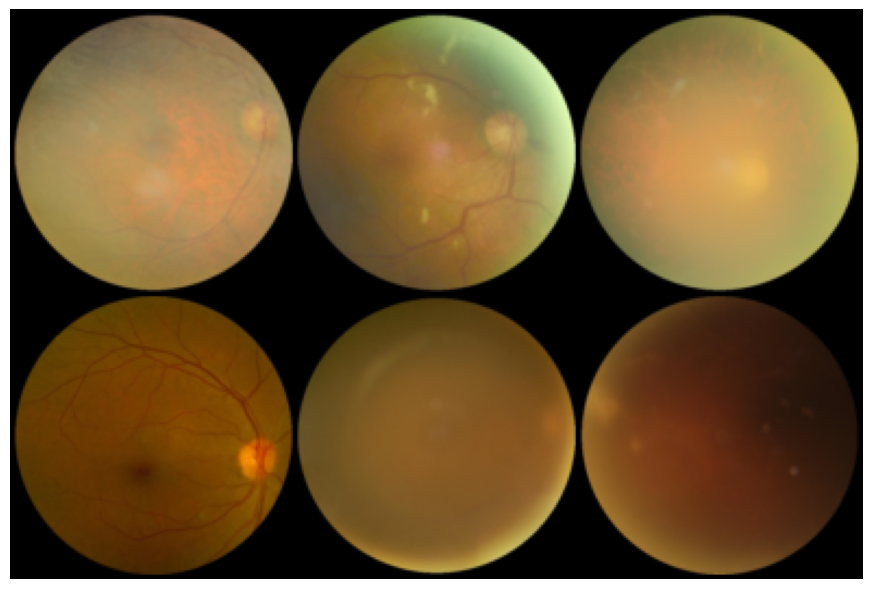

Labels: tensor([2, 1, 0, 1, 0, 0])


In [28]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing images to 128x128
    transforms.ToTensor()           # Converting images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root="D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train", transform=transform)

# Call the function to show images
show_transformed_images(dataset)

224 pixels

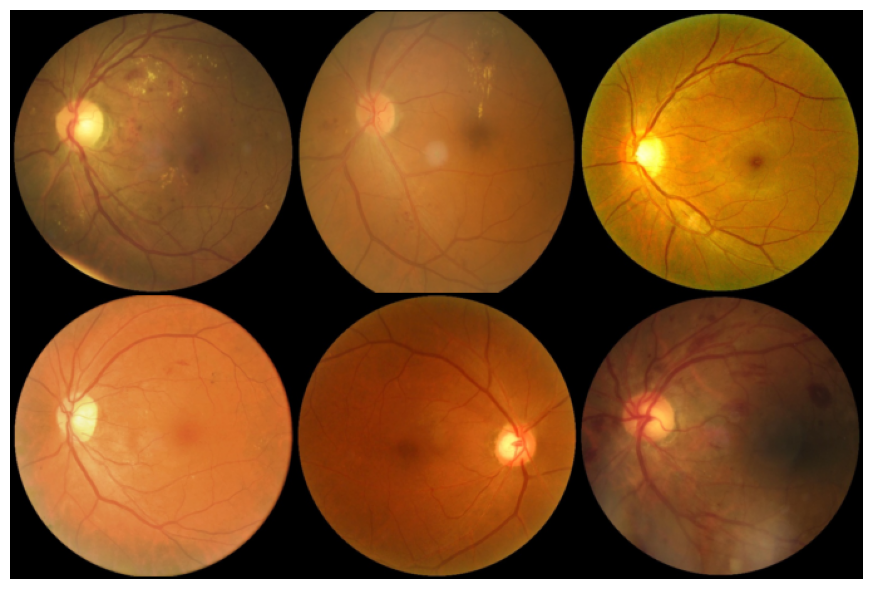

Labels: tensor([1, 1, 1, 1, 2, 1])


In [29]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to 128x128
    transforms.ToTensor()           # Converting images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root="D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train", transform=transform)

# Call the function to show images
show_transformed_images(dataset)

448 pixels

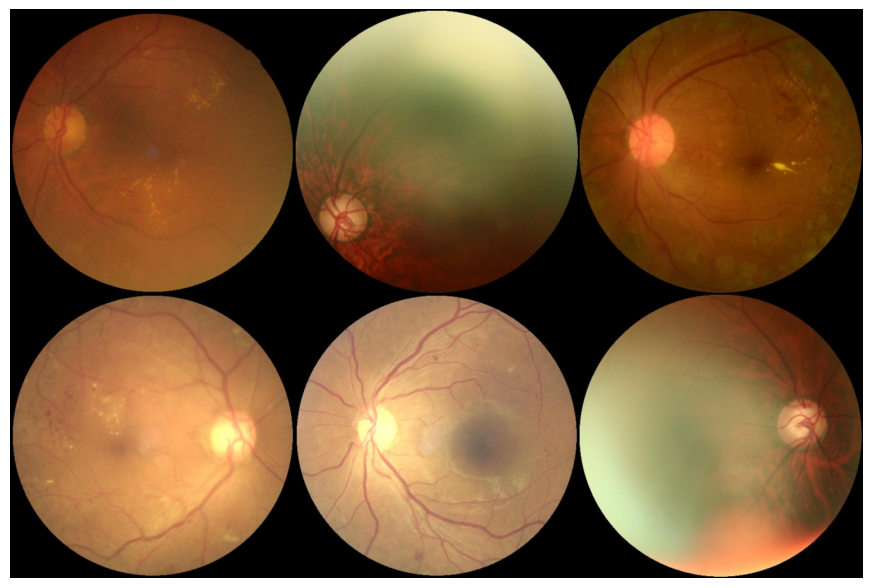

Labels: tensor([1, 2, 1, 1, 1, 2])


In [30]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((448,448)),  # Resizing images to 128x128
    transforms.ToTensor()           # Converting images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root="D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train", transform=transform)

# Call the function to show images
show_transformed_images(dataset)

orginal image

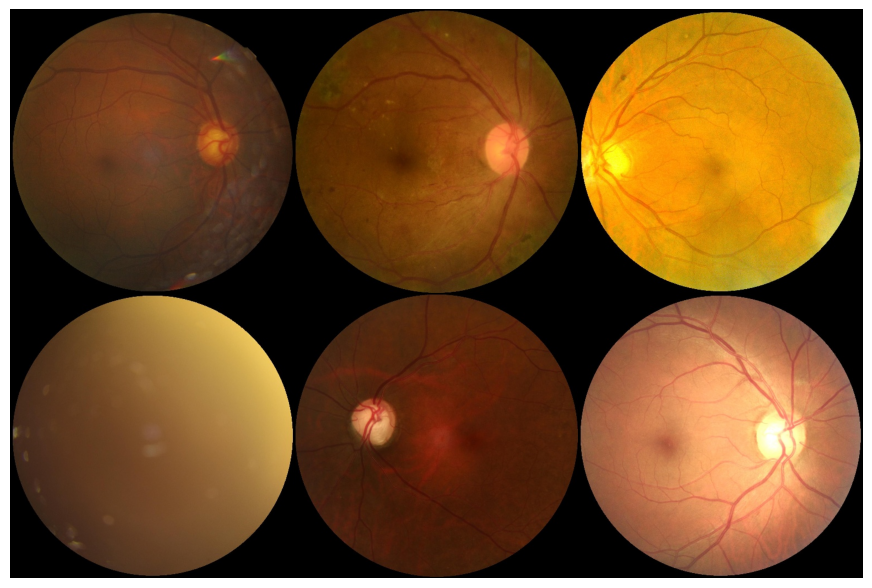

Labels: tensor([2, 1, 1, 0, 2, 1])


In [31]:
# Define your transformations
transform = transforms.Compose([
    transforms.ToTensor()           # Converting images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root="D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train", transform=transform)

# Call the function to show images
show_transformed_images(dataset)

Counting no. of images

In [32]:
import os

def count_images_in_directory(directory_path):
    class_counts = {}
    for class_name in os.listdir(directory_path):
        class_dir = os.path.join(directory_path, class_name)
        if os.path.isdir(class_dir):
            # Counting files with common image extensions
            image_count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            class_counts[class_name] = image_count
    return class_counts

# Loading the images from train and test folders
train_count_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train"
val_count_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\test"

# Counting total classes of images in the folders
train_class_counts = count_images_in_directory(train_count_dir)
val_class_counts = count_images_in_directory(val_count_dir)

print(f"Training images count by class: {train_class_counts}")
print(f"Validation images count by class: {val_class_counts}")

Training images count by class: {'Cataract': 210, 'Diabetes': 712, 'Glaucoma': 160}
Validation images count by class: {'Cataract': 228, 'Diabetes': 762, 'Glaucoma': 179}


# ResNet50 (pre-trained model)

In [33]:
def train_and_evaluate_resnet_kfold(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device, k: int = 5):
    num_classes = len(dataset.classes)  # Getting the number of classes from the dataset
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Initializing K-fold cross-validation

    best_model = None
    best_acc = 0
    best_acc_fold = 0
    fold_results = []

    # Iterating through each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\nFold {fold + 1}/{k}")

        # Creating data loaders for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)

        # Loading the pre-trained ResNet50 model
        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()

        # Defining the optimizer
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_acc_history = []
        val_acc_history = []
        epoch_losses = []
        val_losses = []
        best_epoch_labels = []
        best_epoch_preds = []

        best_epoch = -1
        best_epoch_acc = 0
        best_epoch_state = None

        # Iterating through each epoch
        for epoch in range(n_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            # Iterating through the training data
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Resetting the gradients
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100.0 * correct_train / total_train
            train_acc_history.append(train_accuracy)
            epoch_loss = running_loss / total_train
            # Storing the training loss
            epoch_losses.append(epoch_loss)

            # Validating phase
            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            fold_labels = []
            fold_preds = []

            # Disabling gradient computation
            with torch.no_grad():
                # Iterating through the validation data
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    fold_labels.extend(labels.cpu().numpy())
                    fold_preds.extend(predicted.cpu().numpy())

            val_accuracy = 100.0 * correct_val / total_val
            val_acc_history.append(val_accuracy)
            val_loss = running_val_loss / total_val
            val_losses.append(val_loss)

            # Checking if the current epoch has the best accuracy
            if val_accuracy > best_epoch_acc:
                best_epoch_acc = val_accuracy
                best_epoch = epoch
                best_epoch_state = model.state_dict()
                best_epoch_labels = fold_labels.copy()
                best_epoch_preds = fold_preds.copy()

            print(f"Epoch {epoch + 1}:")
            print(f"  -- Training dataset. Classified {correct_train} out of {total_train} images to correct labels ({train_accuracy:.3f}%). Epoch loss: {epoch_loss:.3f}")
            print(f"   - Validation dataset. Classified {correct_val} out of {total_val} images to correct labels ({val_accuracy:.3f}%). Epoch loss: {val_loss:.3f}")

        # Plotting loss metrics for this fold
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, n_epochs + 1), epoch_losses, label='Training Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting accuracy metrics for this fold
        plt.subplot(1, 2, 2)
        plt.plot(range(1, n_epochs + 1), train_acc_history, label='Train Accuracy')
        plt.plot(range(1, n_epochs + 1), val_acc_history, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Plotting confusion matrix for the best epoch of this fold
        cm_best_epoch = confusion_matrix(best_epoch_labels, best_epoch_preds, labels=list(range(num_classes)))

        print(f"\nClassification Report for the Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
        print(classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes))

        # Saving the best model of this fold if it has the highest validation accuracy
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_acc_fold = fold
            best_model = best_epoch_state

        fold_results.append({
            'model_state': best_epoch_state,
            'val_accuracy': best_epoch_acc,
            'fold': fold + 1,
            'confusion_matrix': cm_best_epoch,
            'classification_report': classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes)
        })

    # Saving the best model after all folds
    if best_model:
        torch.save(best_model, f'resnet_ims448_model_fold_{best_acc_fold + 1}_accuracy_{best_acc:.2f}.pth')

    # Comparing all best models and printing the best one
    best_overall = max(fold_results, key=lambda x: x['val_accuracy'])
    print(f"\nBest overall model from fold {best_overall['fold']} with validation accuracy: {best_overall['val_accuracy']:.2f}%")

    # Printing confusion matrix and classification report for the best overall model
    print(f"\nConfusion Matrix for the best model (Fold {best_overall['fold']}):")
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_overall['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix - Best Model (Fold {best_overall["fold"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for the best model (Fold {best_overall['fold']}):")
    print(best_overall['classification_report'])

    print("\nTraining and evaluation finished.")



# Resnet 128 x128 pixels

In [34]:
''' # Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing images to 128x128
    transforms.ToTensor(),  # Converting images to tensors
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 5

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k) '''

" # Defining transformations for data preprocessing\ntransform = transforms.Compose([\n    transforms.Resize((128, 128)),  # Resizing images to 128x128\n    transforms.ToTensor(),  # Converting images to tensors\n])\n\n# Creating the dataset\ndataset = datasets.ImageFolder(root=train_dir, transform=transform)\n\n# Defining the device\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\n# Defining the number of epochs and k for k-fold cross-validation\nn_epochs = 10\nk = 5\n\n# Calling the function to train and evaluate the model with k-fold cross-validation\ntrain_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k) "

# Resnet 224 x 224 pixels

In [35]:
''' # Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to 224x224
    transforms.ToTensor(),  # Converting images to tensors
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 5

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k) '''

" # Defining transformations for data preprocessing\ntransform = transforms.Compose([\n    transforms.Resize((224, 224)),  # Resizing images to 224x224\n    transforms.ToTensor(),  # Converting images to tensors\n])\n\n# Creating the dataset\ndataset = datasets.ImageFolder(root=train_dir, transform=transform)\n\n# Defining the device\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\n# Defining the number of epochs and k for k-fold cross-validation\nn_epochs = 10\nk = 5\n\n# Calling the function to train and evaluate the model with k-fold cross-validation\ntrain_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k) "

# Resnet 448 x 448 pixels

In [36]:
''' # Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # Resizing images to 448x448
    transforms.ToTensor(),  # Converting images to tensors
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 5

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k) '''

" # Defining transformations for data preprocessing\ntransform = transforms.Compose([\n    transforms.Resize((448, 448)),  # Resizing images to 448x448\n    transforms.ToTensor(),  # Converting images to tensors\n])\n\n# Creating the dataset\ndataset = datasets.ImageFolder(root=train_dir, transform=transform)\n\n# Defining the device\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\n# Defining the number of epochs and k for k-fold cross-validation\nn_epochs = 10\nk = 5\n\n# Calling the function to train and evaluate the model with k-fold cross-validation\ntrain_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k) "

# Resnet 

In [37]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np
import torchvision.models as models

In [38]:


# Paths
train_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train"
save_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\saved_models"
os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

# Defining device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training settings
n_epochs = 10
k = 5

# Define image resolutions to train on
image_sizes = [128, 224, 448]  # Resolutions to train
models_paths = {size: os.path.join(save_dir, f"best_resnet_{size}x{size}.pth") for size in image_sizes}

# Function to train and save model
def train_and_save_best_model(img_size, dataset, model_path):
    """Train and save the best model for a given image size."""
    print(f"\n🚀 Training for {img_size}x{img_size} resolution...\n")

    best_model_state = None
    best_val_acc = 0

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\nFold {fold + 1}/{k}")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        model = models.resnet50(pretrained=True)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, len(dataset.classes))
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(n_epochs):
            model.train()
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_acc = 100.0 * correct_train / total_train

            # Validation Phase
            model.eval()
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_acc = 100.0 * correct_val / total_val
            print(f"Epoch {epoch + 1}/{n_epochs} - Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

            # Save the best model based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()

    # Save the best overall model
    if best_model_state:
        torch.save(best_model_state, model_path)
        print(f"\n✅ Best model saved at {model_path} with accuracy {best_val_acc:.2f}%")

# Function to load and evaluate model
def load_and_evaluate_model(img_size, dataset, model_path):
    """Load and evaluate the trained model."""
    print(f"\n✅ Found saved model for {img_size}x{img_size}! Loading for evaluation...")

    model = models.resnet50(pretrained=False)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, len(dataset.classes))

    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    test_loader = DataLoader(dataset, batch_size=32, shuffle=False)
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"✅ Evaluation Completed! Accuracy on dataset ({img_size}x{img_size}): {accuracy:.2f}%\n")

# Loop through all resolutions and train/evaluate accordingly
for img_size in image_sizes:
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),  # Resizing images
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = datasets.ImageFolder(root=train_dir, transform=transform)

    # Check if model already exists
    if os.path.exists(models_paths[img_size]):
        load_and_evaluate_model(img_size, dataset, models_paths[img_size])
    else:
        train_and_save_best_model(img_size, dataset, models_paths[img_size])



✅ Found saved model for 128x128! Loading for evaluation...
✅ Evaluation Completed! Accuracy on dataset (128x128): 91.87%


✅ Found saved model for 224x224! Loading for evaluation...
✅ Evaluation Completed! Accuracy on dataset (224x224): 87.89%


✅ Found saved model for 448x448! Loading for evaluation...
✅ Evaluation Completed! Accuracy on dataset (448x448): 85.86%



# Fine tuning

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report





✅ Found saved model for 128x128! Loading for evaluation...
✅ Evaluation Completed! Accuracy on dataset (128x128): 96.21%


🔹 Classification Report:
              precision    recall  f1-score   support

    Cataract       0.94      0.98      0.96       210
    Diabetes       0.98      0.97      0.97       712
    Glaucoma       0.90      0.91      0.91       160

    accuracy                           0.96      1082
   macro avg       0.94      0.95      0.95      1082
weighted avg       0.96      0.96      0.96      1082



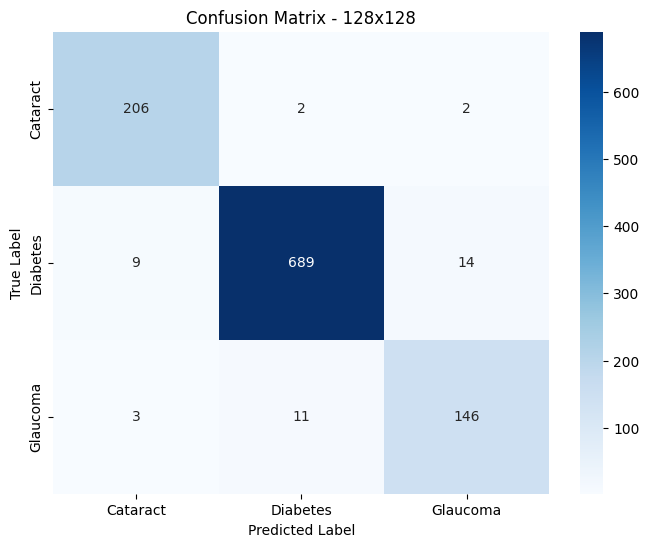


✅ Found saved model for 224x224! Loading for evaluation...
✅ Evaluation Completed! Accuracy on dataset (224x224): 92.24%


🔹 Classification Report:
              precision    recall  f1-score   support

    Cataract       0.96      0.93      0.95       210
    Diabetes       0.93      0.97      0.95       712
    Glaucoma       0.83      0.68      0.75       160

    accuracy                           0.92      1082
   macro avg       0.91      0.86      0.88      1082
weighted avg       0.92      0.92      0.92      1082



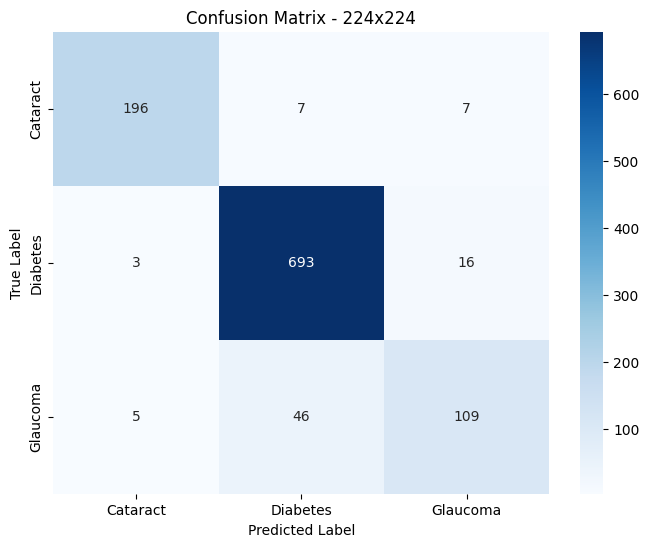


✅ Found saved model for 448x448! Loading for evaluation...
✅ Evaluation Completed! Accuracy on dataset (448x448): 96.95%


🔹 Classification Report:
              precision    recall  f1-score   support

    Cataract       0.93      0.98      0.96       210
    Diabetes       0.99      0.98      0.98       712
    Glaucoma       0.94      0.93      0.93       160

    accuracy                           0.97      1082
   macro avg       0.95      0.96      0.96      1082
weighted avg       0.97      0.97      0.97      1082



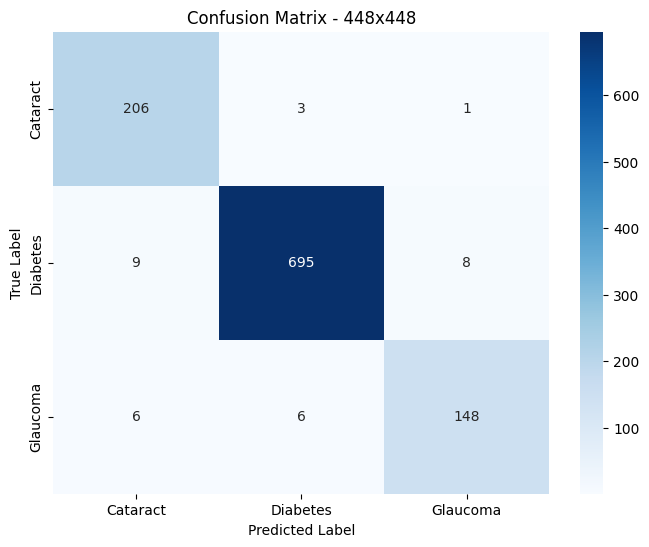

In [41]:
# Training Settings
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Paths
train_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train"
test_dir = "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\test"

# Define Image Sizes to Train On
IMAGE_SIZES = [128, 224, 448]

# Function to Define Transformations
def get_transforms(img_size):
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Function to Train and Save the Best Model
def train_and_save_best_model(img_size, dataset, model_path):
    print(f"\n🚀 Training for {img_size}x{img_size} resolution...\n")

    # Split into Training (80%) and Validation (20%)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Load Pretrained ResNet50 Model
    model = models.resnet50(pretrained=True)

    # Freeze all layers except the last 10 for fine-tuning
    for name, param in model.named_parameters():
        if name.startswith("layer4") or name.startswith("fc"):  # Last block + FC layer
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Modify Fully Connected Layer
    num_classes = len(dataset.classes)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model = model.to(DEVICE)

    # Define Loss Function and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Training Loop
    best_acc = 0
    best_model_state = None

    for epoch in range(EPOCHS):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = 100.0 * correct / total
        train_loss /= total

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_acc = 100.0 * correct / total
        val_loss /= total

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

        # Save Best Model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict()
            torch.save(best_model_state, model_path)
            print(f"✅ Model Saved: {model_path} (Best Acc: {best_acc:.2f}%)")

        scheduler.step()

    print(f"\n🔥 Best Model Achieved {best_acc:.2f}% Validation Accuracy!")

# Function to Load and Evaluate Model
def load_and_evaluate_model(img_size, dataset, model_path):
    print(f"\n✅ Found saved model for {img_size}x{img_size}! Loading for evaluation...")

    model = models.resnet50(pretrained=False)
    in_features = model.fc.in_features
    num_classes = len(dataset.classes)
    model.fc = nn.Linear(in_features, num_classes)

    model.load_state_dict(torch.load(model_path))
    model = model.to(DEVICE)
    model.eval()

    test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = 100.0 * correct / total
    print(f"✅ Evaluation Completed! Accuracy on dataset ({img_size}x{img_size}): {accuracy:.2f}%\n")

    # Classification Report
    print("\n🔹 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {img_size}x{img_size}")
    plt.show()

# Loop Through All Resolutions
for img_size in IMAGE_SIZES:
    model_path = f"resnet50_finetuned_{img_size}.pth"

    # Load Dataset with Corresponding Image Size
    transform = get_transforms(img_size)
    dataset = datasets.ImageFolder(root=train_dir, transform=transform)

    # Check if Model Exists
    if os.path.exists(model_path):
        load_and_evaluate_model(img_size, dataset, model_path)
    else:
        train_and_save_best_model(img_size, dataset, model_path)

# XAI

# Gradcam

In [69]:
!pip install torch torchvision numpy opencv-python matplotlib


In [70]:
# Grad-CAM Function
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms

def get_gradcam_heatmap(model, image, class_idx, layer_name="layer4"):
    """Generate Grad-CAM heatmap for a given image and model."""
    
    # Extract target layer
    target_layer = dict([*model.named_modules()])[layer_name]
    
    # Hooks for gradients and activations
    activations = None
    gradients = None
    
    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]
    
    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    image = image.unsqueeze(0).to(DEVICE)
    model.eval()
    output = model(image)
    class_score = output[0, class_idx]
    
    # Backward pass
    model.zero_grad()
    class_score.backward()
    
    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Compute Grad-CAM heatmap
    pooled_grads = gradients.mean(dim=[0, 2, 3])
    heatmap = (activations * pooled_grads.view(1, -1, 1, 1)).sum(dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= heatmap.max()  # Normalize
    
    return heatmap

def overlay_heatmap_on_image(image, heatmap, alpha=0.4):
    """Overlay Grad-CAM heatmap onto the original image."""
    
    # Convert tensor image to numpy
    image = image.cpu().numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0,1]

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    
    # Convert heatmap to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Blend images
    superimposed_img = (1 - alpha) * image + alpha * heatmap
    return np.clip(superimposed_img, 0, 1)

def apply_gradcam(model, image_path, transform, class_names):
    """Apply Grad-CAM and visualize results."""
    
    # Load image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).to(DEVICE)
    
    # Predict class
    model.eval()
    output = model(input_tensor.unsqueeze(0))
    _, pred_class = torch.max(output, 1)
    
    # Generate Grad-CAM
    heatmap = get_gradcam_heatmap(model, input_tensor, pred_class.item())

    # Overlay heatmap
    result_image = overlay_heatmap_on_image(input_tensor, heatmap)
    
    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image ({class_names[pred_class]})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(result_image)
    plt.title(f"Grad-CAM Visualization")
    plt.axis("off")

    plt.show()


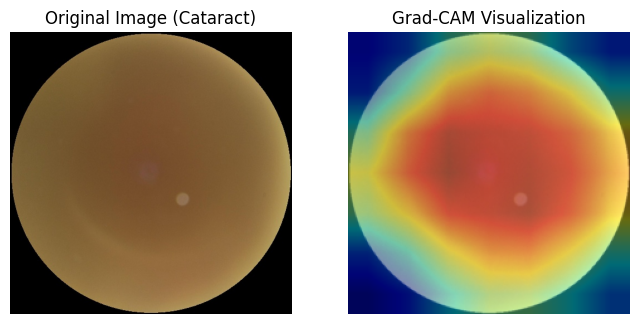

In [71]:
from PIL import Image

def evaluate_with_gradcam(img_size, model_path, sample_image_path):
    """Load the trained model and apply Grad-CAM on a sample image."""
    
    # Load model
    model = models.resnet50(pretrained=False)
    in_features = model.fc.in_features
    num_classes = len(dataset.classes)
    model.fc = nn.Linear(in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE).eval()
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Run Grad-CAM
    apply_gradcam(model, sample_image_path, transform, dataset.classes)

# Example Usage
evaluate_with_gradcam(224, "resnet50_finetuned_448.pth", "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\test\\Cataract\\218_right.jpg")


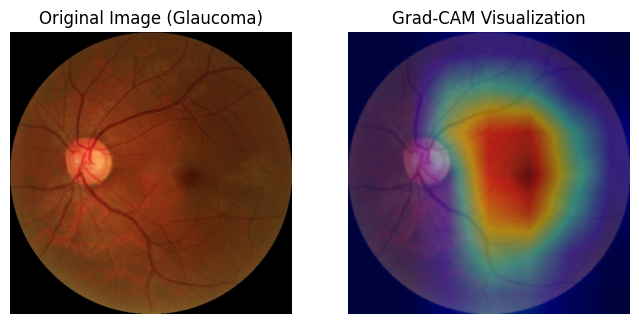

In [72]:
# Example Usage
evaluate_with_gradcam(224, "resnet50_finetuned_448.pth", "D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\train\\Glaucoma\\1351_left.jpg")

# LIME

In [46]:
!pip install lime


In [47]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image
import os

In [48]:
# LIME Function


In [49]:
# Define Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
# Load Trained ResNet50 Model
def load_model(model_path, num_classes):
    model = models.resnet50(pretrained=False)
    in_features = model.fc.in_features

    # Load the saved state dict
    state_dict = torch.load(model_path, map_location=DEVICE)

    # Remove mismatched fc layer weights
    state_dict.pop("fc.weight", None)
    state_dict.pop("fc.bias", None)

    # Load model parameters (excluding fc layer)
    model.load_state_dict(state_dict, strict=False)

    # Redefine FC layer to match the new number of classes
    model.fc = torch.nn.Linear(in_features, num_classes)
    
    model.to(DEVICE)
    model.eval()
    return model

# Define Preprocessing Transform
def preprocess_image(image_path, img_size):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0), image  # Return tensor + original image

# Define Prediction Function for LIME
def predict_fn(images):
    images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2).to(DEVICE)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()  # Ensure proper probability output
    return probs

# Apply LIME to Explain Image Classification
def apply_lime(model, image_path, img_size, class_names):
    # Preprocess Image
    input_tensor, original_image = preprocess_image(image_path, img_size)
    input_tensor = input_tensor.to(DEVICE)

    # Predict Class
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    predicted_label = class_names[predicted_class]
    print(f"Predicted Class: {predicted_label}")

    # Convert Image to Numpy
    image_np = np.array(original_image)

    # Create LIME Explainer
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image_np, 
        predict_fn, 
        top_labels=2,  # Get the top predicted class by LIME
        hide_color=0, 
        num_samples=1000
    )

    # Fix: Get LIME’s actual top predicted class
    label_to_explain = explanation.top_labels[0]

    # Get Heatmap
    temp, mask = explanation.get_image_and_mask(
        label_to_explain,  # Use LIME's top label
        positive_only=True, 
        num_features=10, 
        hide_rest=True
    )

    # Visualize LIME Results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f"Original Image ({predicted_label})")

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME Explanation")

    plt.show()

Predicted Class: Glaucoma


100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]


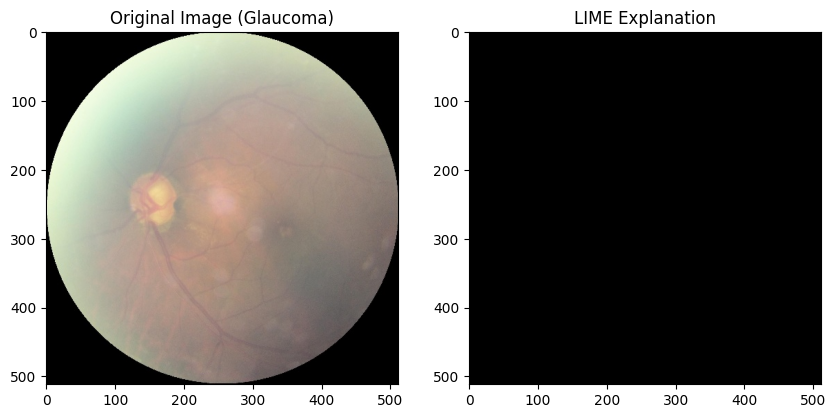

In [56]:
# Example Usage
if __name__ == "__main__":
    model_path = "resnet50_finetuned_224.pth"
    image_path = r"D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\test\\Glaucoma\\1215_left.jpg"
    img_size = 224
    class_names = ["Cataract", "Diabetic Retinopathy", "Glaucoma"]  # Ensure this matches model output

    # Load Model
    model = load_model(model_path, len(class_names))
    
    # Run LIME
    apply_lime(model, image_path, img_size, class_names)

Predicted Class: Cataract


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..148.0].


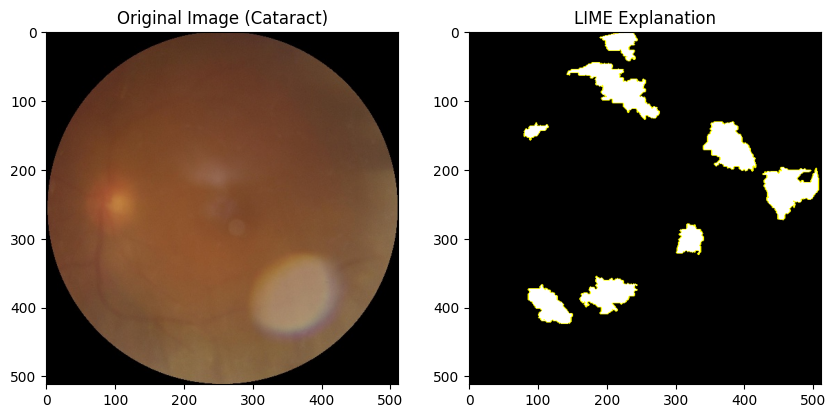

In [57]:
# Example Usage
if __name__ == "__main__":
    model_path = "resnet50_finetuned_448.pth"
    image_path = r"D:\\MIA\\6th Sem\\PACS\\ds\\classified_images\\test\\Cataract\\2225_right.jpg"
    img_size = 224
    class_names = ["Cataract", "Diabetic Retinopathy", "Glaucoma"]  # Ensure this matches model output

    # Load Model
    model = load_model(model_path, len(class_names))
    
    # Run LIME
    apply_lime(model, image_path, img_size, class_names)

# Predicting eye images using other datasets

Gradcam

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001712563B880>
Traceback (most recent call last):
  File "c:\Users\PRABHAKARAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "c:\Users\PRABHAKARAN\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


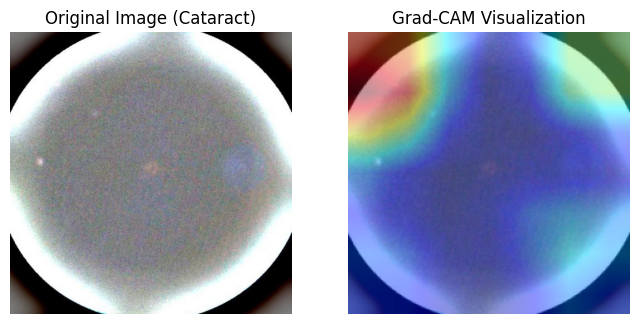

In [ ]:
# Example Usage
evaluate_with_gradcam(224, "resnet50_finetuned_448.pth","D:\\MIA\\6th Sem\\PACS\\New folder\\Retinal Fundus Images\\test\\7.Cataract\\Cataract1062_right_0_34.jpeg")

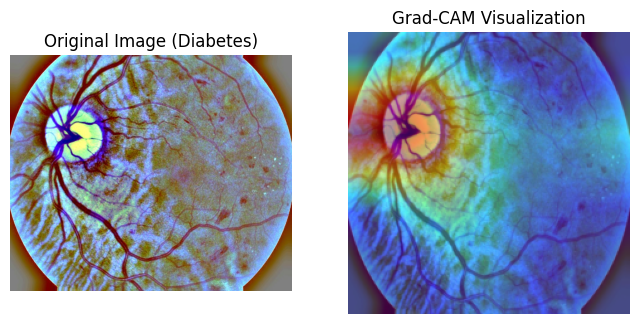

In [79]:
# Example Usage

evaluate_with_gradcam(224, "resnet50_finetuned_448.pth","D:\\MIA\\6th Sem\\PACS\\New folder\\Retinal Fundus Images\\test\\5.Severe DR\\Severe DR13270_left_0_5594.jpeg")

LIME

Predicted Class: Glaucoma


100%|██████████| 1000/1000 [04:54<00:00,  3.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


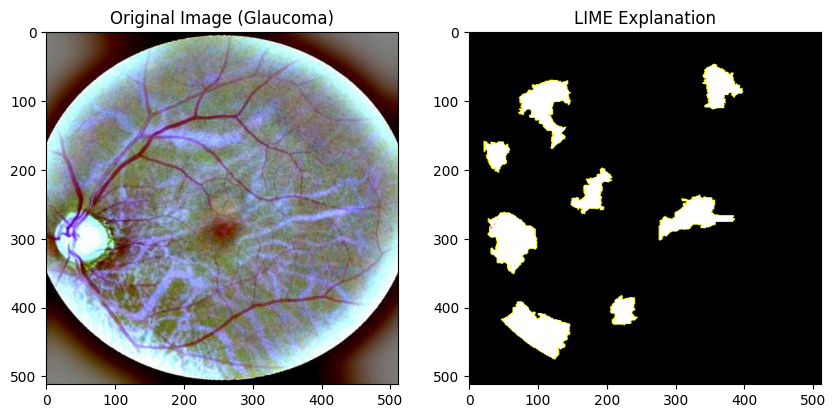

In [92]:
# Example Usage
if __name__ == "__main__":
    model_path = "resnet50_finetuned_224.pth"
    image_path = r"D:\\MIA\\6th Sem\\PACS\\New folder\\Retinal Fundus Images\\test\\10.Glaucoma\\Glaucoma1266_right_0_8601.jpeg"
    img_size = 224
    class_names = ["Cataract", "Diabetic Retinopathy", "Glaucoma"]  # Ensure this matches model output

    # Load Model
    model = load_model(model_path, len(class_names))
    
    # Run LIME
    apply_lime(model, image_path, img_size, class_names)

Predicted Class: Diabetic Retinopathy


100%|██████████| 1000/1000 [26:59<00:00,  1.62s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


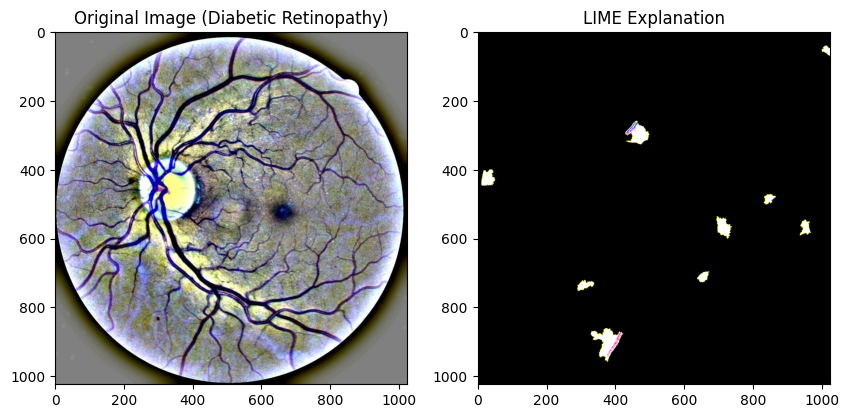

In [89]:
# Example Usage
if __name__ == "__main__":
    model_path = "resnet50_finetuned_448.pth"
    image_path = r"D:\\MIA\\6th Sem\\PACS\\New folder\\Retinal Fundus Images\test\\3.Mild DR\\4781_left.jpeg"
    class_names = ["Cataract", "Diabetic Retinopathy", "Glaucoma"]  # Ensure this matches model output

    # Load Model
    model = load_model(model_path, len(class_names))
    
    # Run LIME
    apply_lime(model, image_path, img_size, class_names)